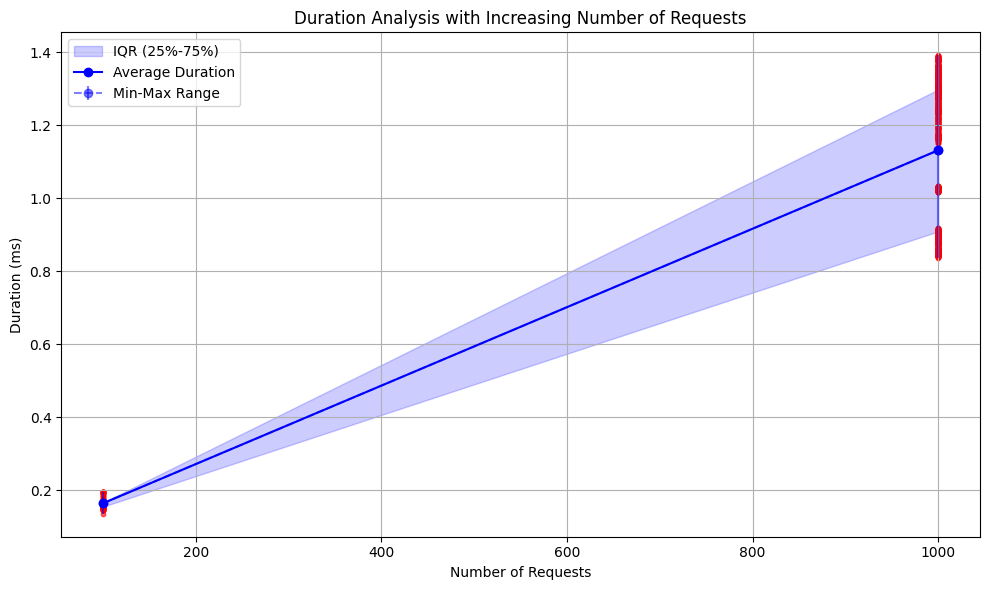

In [32]:
import asyncio
import aiohttp
import time
import matplotlib.pyplot as plt
import numpy as np
import json
import random



with open('primes.json', 'r') as file:
    primes = json.load(file)

async def fetch_app_output():
    
    p, q = random.sample(primes, 2)  # Randomly select two primes
    phi = (p - 1) * (q - 1)  # Calculate phi
    
    while True:
        e = random.randint(2, phi - 1)  # Randomly select e
        if np.gcd(e, phi) == 1:
            break

    params = {'e': str(e), 'phi': str(phi)}  # Prepare parameters


    async with aiohttp.ClientSession() as session:
        start_time = time.perf_counter()
        async with session.get(f'http://192.168.0.100/compute-inverse', params=params) as response:
            output = await response.json()
            end_time = time.perf_counter()

    assert(int(output["privateKey"]) * e % phi == 1)  # Check if the result is correct

    return end_time - start_time

durations = []
x = [100, 1000]

for num_requests in x:
    tasks = [fetch_app_output() for _ in range(num_requests)]
    durations.append(await asyncio.gather(*tasks))

# Calculate statistics for durations
means = [np.mean(d) for d in durations]
q1 = [np.percentile(d, 25) for d in durations]
q3 = [np.percentile(d, 75) for d in durations]
min_vals = [np.min(d) for d in durations]
max_vals = [np.max(d) for d in durations]

# Plot
plt.figure(figsize=(10, 6))

# IQR area
plt.fill_between(x, q1, q3, color='blue', alpha=0.2, label='IQR (25%-75%)')

# Min-Max range (as error bars)
plt.errorbar(x, means, yerr=[np.array(means) - np.array(min_vals), 
                                                        np.array(max_vals) - np.array(means)],
                fmt='o', color='blue', linestyle='--', alpha=0.5, label='Min-Max Range')

# Mean values
plt.plot(x, means, 'o-', color='blue', label='Average Duration')

# Data points
for x, d in zip(x, durations):
    plt.scatter([x]*len(d), d, color='red', s=10, alpha=0.6)

# Axis labels and legend
plt.xlabel('Number of Requests')
plt.ylabel('Duration (ms)')
plt.title('Duration Analysis with Increasing Number of Requests')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
import os
import asyncio
import pandas as pd
from datetime import datetime
import time


def crash_simulator(num, action):
    """
    Simulate a crash by running a shell script with the given parameters.
    :param num: Number of requests to simulate.
    :param action: Action to perform (e.g., "down" or "up").
    """

    os.system(f"./crash-simulation.sh 192.168.0.1{num} {action} >> /dev/null")

# Initialize a list to store the data
data = []

async def monitor_requests():
    start_time = time.time()
    while time.time() - start_time < 10:  # Run for 10 seconds
        timestamp = datetime.now()  # Record the start time of the request
        duration = await fetch_app_output()  # Call the function and get the duration
        data.append({'timestamp': timestamp, 'duration': duration})
        await asyncio.sleep(0.01)  # Wait for 0.01 seconds (100 requests per second)

# Run the monitoring
task = asyncio.create_task(monitor_requests())

# If the process has been running for 5 seconds, call crash_simulator
await asyncio.sleep(3)
crash_simulator(2, "down")
await asyncio.sleep(3)
crash_simulator(3, "down")

# Wait for the monitoring task to finish
await task


crash_simulator(2, "up")
crash_simulator(3, "up")
time.sleep(10)  # Wait for 2 seconds to ensure the script has time to run

# Create a DataFrame from the collected data
df_monitor = pd.DataFrame(data)

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


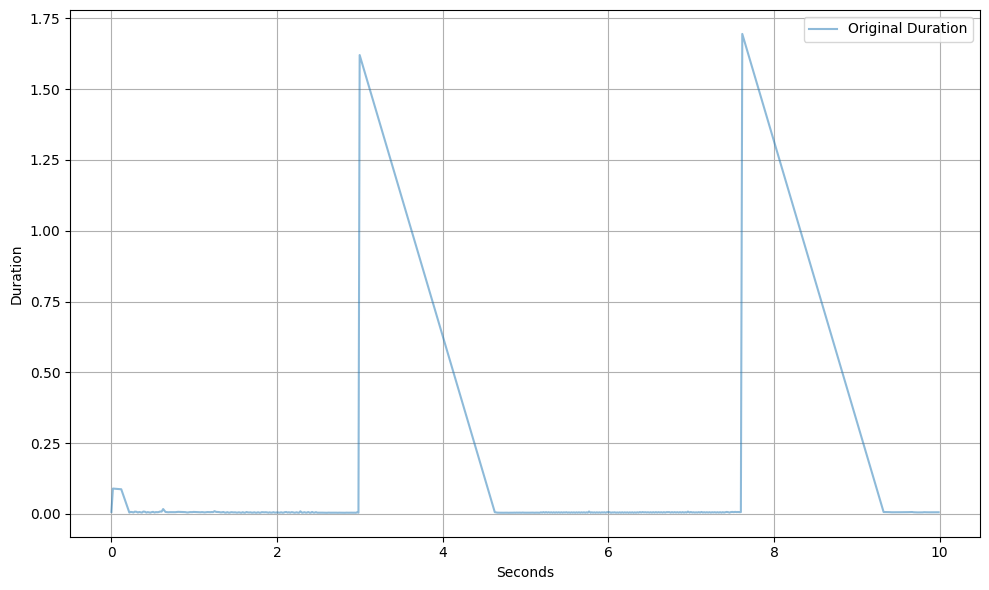

In [39]:
# Berechnung der Sekunden seit dem ersten Timestamp
df_monitor['seconds'] = (df_monitor['timestamp'] - df_monitor['timestamp'].iloc[0]).dt.total_seconds()

# Plotten der Daten
plt.figure(figsize=(10, 6))
plt.plot(df_monitor['seconds'], df_monitor['duration'], label='Original Duration', alpha=0.5)
plt.xlabel('Seconds')
plt.ylabel('Duration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()